In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
!pip install yfinance --upgrade --no-cache-dir

In [3]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/MyDrive/RP"

Mounted at /content/drive
/content/drive/MyDrive/RP


In [4]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("LT.NS", start="2022-01-03").reset_index()
df.to_csv('/content/LT.csv',index=False)
df.head()

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


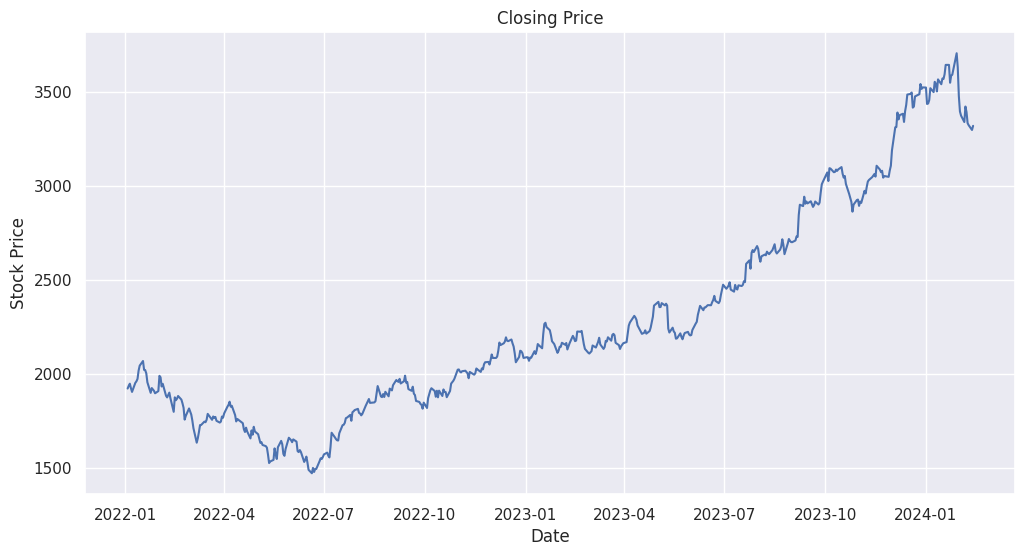

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [6]:
df = pd.read_csv('/content/LT.csv')

### Policy Gradient agent

In [7]:
import tensorflow as tf
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [8]:
!pip install --upgrade tensorflow

In [9]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 600, checkpoint = 30, initial_money = initial_money)

Instructions for updating:
non-resource variables are not supported in the long term
<ipython-input-7-0dc68c16d92b>:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
<ipython-input-7-0dc68c16d92b>:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
<ipython-input-7-0dc68c16d92b>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_history = np.array(ep_history)


epoch: 30, total rewards: 4952.400146.3, cost: -2236.758545, total money: 14952.400146
epoch: 60, total rewards: 5554.198608.3, cost: -3002.051514, total money: 15554.198608
epoch: 90, total rewards: 5811.798828.3, cost: -2531.365234, total money: 15811.798828
epoch: 120, total rewards: 4160.149048.3, cost: -2729.413086, total money: 10514.149048
epoch: 150, total rewards: 4240.550171.3, cost: -3025.155273, total money: 14240.550171
epoch: 180, total rewards: 4898.950317.3, cost: -3246.617188, total money: 14898.950317
epoch: 210, total rewards: 2651.198853.3, cost: -4473.918945, total money: 12651.198853
epoch: 240, total rewards: 4214.198853.3, cost: -3320.744385, total money: 14214.198853
epoch: 270, total rewards: 3310.699707.3, cost: -3804.744385, total money: 13310.699707
epoch: 300, total rewards: 2117.849243.3, cost: -3961.513672, total money: 12117.849243
epoch: 330, total rewards: 4567.399048.3, cost: -2970.994385, total money: 10921.399048
epoch: 360, total rewards: 3521.299

In [10]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 1937.550049, total balance 8062.449951
day 2: buy 1 unit at price 1948.599976, total balance 6113.849976
day 3, sell 1 unit at price 1924.500000, investment -0.673534 %, total balance 8038.349976,
day 5: buy 1 unit at price 1953.099976, total balance 6085.250000
day 7: buy 1 unit at price 1974.199951, total balance 4111.050049
day 8: buy 1 unit at price 2018.400024, total balance 2092.650024
day 9: buy 1 unit at price 2044.750000, total balance 47.900024
day 18, sell 1 unit at price 1897.550049, investment -2.619826 %, total balance 1945.450073,
day 19: buy 1 unit at price 1909.199951, total balance 36.250122
day 22, sell 1 unit at price 1933.650024, investment -0.995850 %, total balance 1969.900146,
day 23: buy 1 unit at price 1947.949951, total balance 21.950195
day 25, sell 1 unit at price 1875.599976, investment -4.994427 %, total balance 1897.550171,
day 26: buy 1 unit at price 1888.800049, total balance 8.750122
day 35, sell 1 unit at price 1844.449951,

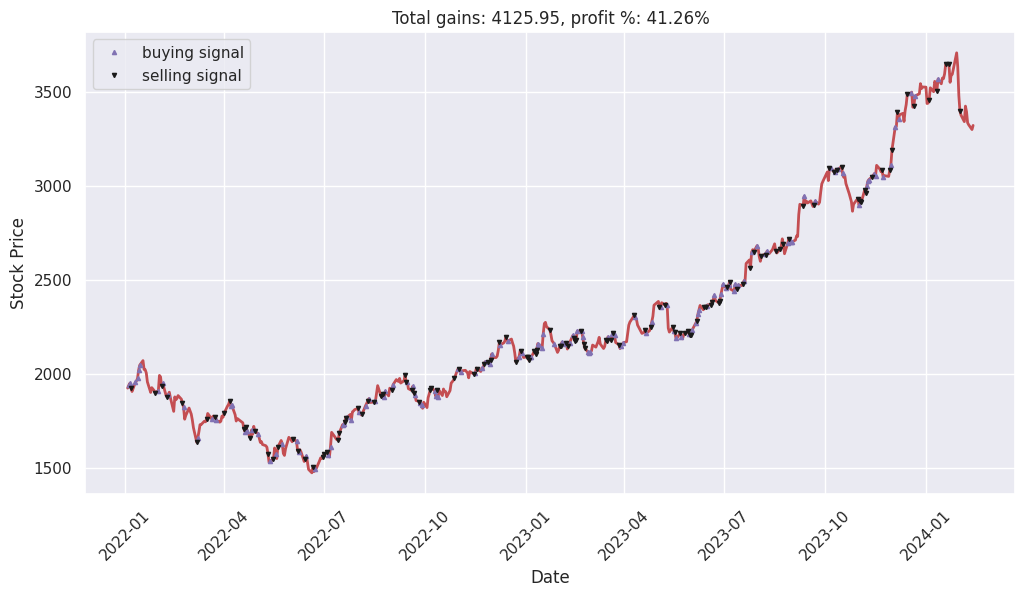

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=3, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=3, color='k', label='selling signal')

plt.title('Total gains: %.2f, profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking monthly profits
monthly_profits = {}

# Loop through buying and selling signals to calculate profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Extract year and month from the buy date
    year = buy_date.year
    month = buy_date.month

    # Calculate profit for the current trade and add to monthly_profits
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price

    # Add the trade profit to the corresponding month
    if year not in monthly_profits:
        monthly_profits[year] = {}
    if month not in monthly_profits[year]:
        monthly_profits[year][month] = []
    monthly_profits[year][month].append(trade_profit)

# Calculate and print average profit for each month, sorted by year and month
for year in sorted(monthly_profits):
    for month in sorted(monthly_profits[year]):
        profits = monthly_profits[year][month]
        average_profit = sum(profits) / len(profits)
        print(f"Year {year}, Month {month}: Average Profit: {average_profit:.2f}")

Year 2022, Month 1: Average Profit: -131.34
Year 2022, Month 2: Average Profit: -80.87
Year 2022, Month 3: Average Profit: -29.43
Year 2022, Month 4: Average Profit: -134.55
Year 2022, Month 5: Average Profit: -55.02
Year 2022, Month 6: Average Profit: 51.36
Year 2022, Month 7: Average Profit: 109.81
Year 2022, Month 8: Average Profit: 69.01
Year 2022, Month 9: Average Profit: 12.56
Year 2022, Month 10: Average Profit: 102.45
Year 2022, Month 11: Average Profit: 81.96
Year 2022, Month 12: Average Profit: -28.70
Year 2023, Month 1: Average Profit: 10.21
Year 2023, Month 2: Average Profit: 3.14
Year 2023, Month 3: Average Profit: 79.48
Year 2023, Month 4: Average Profit: 13.00
Year 2023, Month 5: Average Profit: -32.37
Year 2023, Month 6: Average Profit: 42.58
Year 2023, Month 7: Average Profit: 72.12
Year 2023, Month 8: Average Profit: 180.43
Year 2023, Month 9: Average Profit: 231.22
Year 2023, Month 10: Average Profit: -147.94
Year 2023, Month 11: Average Profit: 181.27
Year 2023, Mon

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]

# Initialize variables for tracking trades and profits
total_trades = 0
total_profit = 0
monthly_profits = {}
current_month = None

# Loop through buying and selling signals to calculate trades and profits
for buy_date, sell_date in zip(date[states_buy], date[states_sell]):
    # Extract year and month from the buy date
    year = buy_date.year
    month = buy_date.month

    # Calculate profit for the current trade and add to total_profit
    buy_price = close[date == buy_date].values[0]
    sell_price = close[date == sell_date].values[0]
    trade_profit = sell_price - buy_price
    total_profit += trade_profit
    total_trades += 1

    # Add the trade profit to the corresponding month
    if year not in monthly_profits:
        monthly_profits[year] = {}
    if month not in monthly_profits[year]:
        monthly_profits[year][month] = []
    monthly_profits[year][month].append(trade_profit)

# Calculate and print metrics
average_profit_per_trade = total_profit / total_trades
annualized_return = (1 + total_profit / 100) ** (12 / len(date.dt.to_period("M").unique())) - 1

print(f"Total Trades: {total_trades}")
print(f"Total Profit: {total_profit:.2f}")
print(f"Average Profit per Trade: {average_profit_per_trade:.2f}")
print(f"Annualized Return: {annualized_return * 100:.2f}%")

Total Trades: 130
Total Profit: 4125.95
Average Profit per Trade: 31.74
Annualized Return: 462.89%
